2025-04-23 20:53:13.870 Python[23345:7703982] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-23 20:53:13.870 Python[23345:7703982] +[IMKInputSession subclass]: chose IMKInputSession_Modern


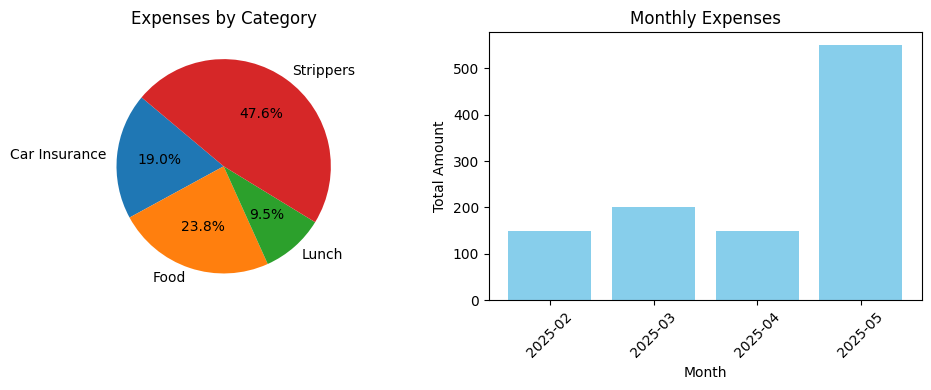

In [1]:
from tkinter import *
from tkinter import ttk, messagebox
import sqlite3
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import pandas as pd
from datetime import datetime

# Track selected entry ID for editing
selected_expense_id = None

# Database Setup
def setup_database():
    conn = sqlite3.connect("expenses.db")
    cursor = conn.cursor()
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS expenses (
            id INTEGER PRIMARY KEY,
            amount REAL,
            category TEXT,
            date TEXT
        )
    """)
    conn.commit()
    conn.close()

# Save Expense to Database
def save_expense(amount, category, date):
    try:
        conn = sqlite3.connect("expenses.db")
        cursor = conn.cursor()
        cursor.execute("INSERT INTO expenses (amount, category, date) VALUES (?, ?, ?)",
                       (amount, category, date))
        conn.commit()
        conn.close()
        messagebox.showinfo("Success", "Expense added successfully!")
    except Exception as e:
        messagebox.showerror("Error", f"An error occurred: {e}")

# Load Expenses
def load_expenses():
    conn = sqlite3.connect("expenses.db")
    cursor = conn.cursor()
    cursor.execute("SELECT id, amount, category, date FROM expenses")
    expenses = cursor.fetchall()
    conn.close()
    return expenses

# Refresh Treeview
def refresh_data():
    for row in tree.get_children():
        tree.delete(row)
    for expense in load_expenses():
        tree.insert("", "end", iid=expense[0], values=expense[1:])

# Clear input fields
def clear_inputs():
    global selected_expense_id
    amount_entry.delete(0, END)
    category_entry.delete(0, END)
    date_entry.delete(0, END)
    date_entry.insert(0, datetime.now().strftime("%Y-%m-%d"))
    selected_expense_id = None

# Add Expense
def add_expense(event=None):
    try:
        amount = float(amount_entry.get())
        category = category_entry.get()
        date = date_entry.get()
        if not category or not date:
            raise ValueError("Category or Date cannot be empty!")
        save_expense(amount, category, date)
        refresh_data()
        clear_inputs()
    except ValueError as ve:
        messagebox.showerror("Invalid Input", f"Error: {ve}")
    except Exception as e:
        messagebox.showerror("Error", f"An unexpected error occurred: {e}")

# Edit Selected Expense
def edit_expense(event=None):
    global selected_expense_id
    selected = tree.selection()
    if not selected:
        messagebox.showwarning("No Selection", "Please select an entry to edit.")
        return
    selected_expense_id = selected[0]
    values = tree.item(selected_expense_id, "values")
    amount_entry.delete(0, END)
    amount_entry.insert(0, values[0])
    category_entry.delete(0, END)
    category_entry.insert(0, values[1])
    date_entry.delete(0, END)
    date_entry.insert(0, values[2])

# Update Expense
def update_expense(event=None):
    global selected_expense_id
    if not selected_expense_id:
        messagebox.showwarning("No Selection", "No expense selected for update.")
        return
    try:
        amount = float(amount_entry.get())
        category = category_entry.get()
        date = date_entry.get()
        if not category or not date:
            raise ValueError("Category or Date cannot be empty!")
        conn = sqlite3.connect("expenses.db")
        cursor = conn.cursor()
        cursor.execute("""
            UPDATE expenses
            SET amount = ?, category = ?, date = ?
            WHERE id = ?
        """, (amount, category, date, selected_expense_id))
        conn.commit()
        conn.close()
        refresh_data()
        clear_inputs()
        messagebox.showinfo("Updated", "Expense updated successfully.")
    except ValueError as ve:
        messagebox.showerror("Invalid Input", f"Error: {ve}")
    except Exception as e:
        messagebox.showerror("Error", f"An error occurred: {e}")

# Delete Expense
def delete_expense(event=None):
    selected = tree.selection()
    if not selected:
        messagebox.showwarning("No Selection", "Please select an entry to delete.")
        return
    expense_id = selected[0]
    try:
        conn = sqlite3.connect("expenses.db")
        cursor = conn.cursor()
        cursor.execute("DELETE FROM expenses WHERE id = ?", (expense_id,))
        conn.commit()
        conn.close()
        refresh_data()
        clear_inputs()
        messagebox.showinfo("Deleted", "Expense deleted successfully.")
    except Exception as e:
        messagebox.showerror("Error", f"An error occurred: {e}")

# Show Charts
def show_charts(event=None):
    expenses = load_expenses()
    df = pd.DataFrame(expenses, columns=["ID", "Amount", "Category", "Date"])

    if df.empty:
        messagebox.showwarning("No Data", "No expense data found to generate charts.")
        return

    df["Date"] = pd.to_datetime(df["Date"])
    df["Month"] = df["Date"].dt.to_period("M").astype(str)

    category_sums = df.groupby("Category")["Amount"].sum()
    monthly_sums = df.groupby("Month")["Amount"].sum().sort_index()

    chart_window = Toplevel(window)
    chart_window.title("Expense Charts")

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    axs[0].pie(category_sums, labels=category_sums.index, autopct="%1.1f%%", startangle=140)
    axs[0].set_title("Expenses by Category")

    axs[1].bar(monthly_sums.index, monthly_sums.values, color="skyblue")
    axs[1].set_title("Monthly Expenses")
    axs[1].set_xlabel("Month")
    axs[1].set_ylabel("Total Amount")
    axs[1].tick_params(axis='x', rotation=45)

    fig.tight_layout()
    canvas = FigureCanvasTkAgg(fig, master=chart_window)
    canvas.draw()
    canvas.get_tk_widget().pack()

# GUI Setup
window = Tk()
window.title("Personal Expense Tracker")
window.config(padx=50, pady=50)

# Labels
Label(window, text="Amount:").grid(row=0, column=0, sticky=W)
Label(window, text="Category:").grid(row=1, column=0, sticky=W)
Label(window, text="Date (YYYY-MM-DD):").grid(row=2, column=0, sticky=W)

# Inputs
amount_entry = Entry(window, width=35)
amount_entry.grid(row=0, column=1, columnspan=2)
category_entry = Entry(window, width=35)
category_entry.grid(row=1, column=1, columnspan=2)
date_entry = Entry(window, width=35)
date_entry.grid(row=2, column=1, columnspan=2)
date_entry.insert(0, datetime.now().strftime("%Y-%m-%d"))

# Buttons
Button(window, text="Add Expense", width=36, command=add_expense).grid(row=3, column=1, columnspan=2, pady=5)
Button(window, text="Edit Selected", width=36, command=edit_expense).grid(row=4, column=1, columnspan=2, pady=5)
Button(window, text="Update Entry", width=36, command=update_expense).grid(row=5, column=1, columnspan=2, pady=5)
Button(window, text="Delete Selected", width=36, command=delete_expense).grid(row=6, column=1, columnspan=2, pady=5)
Button(window, text="Show Charts", width=36, command=show_charts).grid(row=7, column=1, columnspan=2, pady=5)

# Expense Table
tree = ttk.Treeview(window, columns=("Amount", "Category", "Date"), show="headings", height=10)
tree.heading("Amount", text="Amount")
tree.heading("Category", text="Category")
tree.heading("Date", text="Date")
tree.grid(row=8, column=0, columnspan=3, pady=10)

# Shortcuts info
Label(window, text="Shortcuts: Ctrl+A (Add), Ctrl+E (Edit), Ctrl+U (Update), Ctrl+D (Delete), Ctrl+Shift+C (Charts)",
      fg="gray").grid(row=9, column=0, columnspan=3, pady=5)

# Bind Keyboard Shortcuts
window.bind('<Control-a>', add_expense)
window.bind('<Control-e>', edit_expense)
window.bind('<Control-u>', update_expense)
window.bind('<Control-d>', delete_expense)
window.bind('<Control-Shift-C>', show_charts)

# Init
setup_database()
refresh_data()

window.mainloop()
